In [ ]:
# 呼叫PI拍照存DB
# call image
# 裁切目標範圍
# 調整大小
# 裁切小塊
# 辨識是否發芽(邊緣10%不算)
# 存入list

In [2]:
from germination.yy_class import callDB
productionid = '200901002'
dbcnt = callDB('127.0.0.1', 3306, 'root', 'yyos12345678', 'yyostech_2')
data = dbcnt.get_parameter(productionid)
data

In [3]:
import pandas as pd
from germination.yy_class import callDB
import datetime
dbconnect = callDB('127.0.0.1', 3306, 'root', 'yyos12345678', 'yyostech_2')
excel_path = '//Nas001/發芽率e化/'
last_record = dbconnect.get_last_schedule()
filename = '生產排程{} 1-12月'.format(str(datetime.datetime.now().year))
year = str(datetime.datetime.now().year - 1911)
month = "{:02d}".format(datetime.datetime.now().month)
last_month = "{:02d}".format(datetime.datetime.now().month-1)
sheetname = year+month+'排程'
sheetname_last = year+last_month+'排程'
print('last', last_record)
xls = pd.ExcelFile(excel_path + '{}.xlsx'.format(filename))
sheet_list = xls.sheet_names # see all sheet names
for i in sheet_list:
    if sheetname[0:5] in i:
        sheetname = i
        print(sheetname)
        break
for i in sheet_list:
    if sheetname_last in i:
        sheetname_last = i
        print(sheetname_last)
        break    
#         for sheet in [sheetname_last, sheetname]:
df = pd.read_excel(
    excel_path + '{}.xlsx'.format(filename), 
    sheet_name = sheetname, 
    usecols=[1, 3, 5, 9], 
    converters={'生產序號':str,'播種日期':pd.to_datetime,'交貨日':pd.to_datetime,'編號':str}
)

df.notna()


last ('200809025',)
10908排程  
10907排程 


生產序號  播種日期   交貨日    編號
0     True  True  True  True
1     True  True  True  True
2     True  True  True  True
3     True  True  True  True
4     True  True  True  True
..     ...   ...   ...   ...
296  False  True  True  True
297  False  True  True  True
298  False  True  True  True
299  False  True  True  True
300  False  True  True  True

[301 rows x 4 columns]

In [6]:
df_use = df[df['生產序號'].notna()]
df_use
# dbconnect.update_schedule(df_use)

生產序號       播種日期        交貨日      編號
0   200801001 2020-08-01 2020-09-14  213G11
1   200801002 2020-08-01 2020-09-14  H13G11
2   200802003 2020-08-02 2020-09-17  Q13G11
3   200802004 2020-08-02 2020-09-07  G32GD5
4   200802005 2020-08-02 2020-09-14  G12GD5
5   200802006 2020-08-02 2019-09-20  311G43
6   200803007 2020-08-03 2020-09-17  Q13G11
7   200803008 2020-08-03 2020-09-17  D13G11
8   200803009 2020-08-03 2020-09-17  I13G11
9   200803010 2020-08-03 2020-09-14  D13G26
10  200804011 2020-08-04 2020-09-16  713G11
11  200805012 2020-08-05 2020-09-17  213G11
12  200806013 2020-08-06 2020-09-21  313G11
13  200806014 2020-08-06 2020-09-21  D13G11
14  200806015 2020-08-06 2020-09-17  Q12GD5
15  200806016 2020-08-06 2020-09-14  G12GK4
16  200806017 2020-08-06 2020-09-17  D13G26
17  200806018 2020-08-06 2020-09-17  Q13G26
18  200807019 2020-08-07 2020-09-21  G13G11
19  200808020 2020-08-08 2020-09-21  213G11
20  200808021 2020-08-08 2020-09-21  H13G11
21  200809022 2020-08-09 2020-09-24  Q13G11
22  200809023 2020-08-09 2020-09-14  G32GD5
23  200809024 2020-08-09 2020-09-21  G12GD5
24  200809025 2020-08-09 2020-09-27  311G43

In [42]:
from germination.yy_class import germination, callDB, par
from datetime import datetime, timedelta
import math
from linebot.models import TextSendMessage
from linebot import (
    LineBotApi, WebhookHandler
)
import json

secretFileContentJson=json.load(open("D:/YY_DASH/line/line_secret_key",'r'))  # 載入line_secret_key資訊
server_url=secretFileContentJson.get("server_url")  # 讀取webhooks網址

line_bot_api = LineBotApi(secretFileContentJson.get("channel_access_token"))  # 讀取line channel_access_token
handler = WebhookHandler(secretFileContentJson.get("secret_key"))  # 讀取line secret_key
dbcnt = callDB('127.0.0.1', 3306, 'root', 'yyos12345678', 'yyostech_2')
productionid = '200729070'

# 計算今天的發芽率是否有達到 nursery_rate
res_data = dbcnt.get_summary(productionid)
total_sponge = sum(x[3] for x in res_data)*12*8
sum_n = sum(x[4] for x in res_data)
total_perecnt = round((sum_n/total_sponge)*100, 2)
print(total_sponge, sum_n, total_perecnt)
parameter = dbcnt.get_parameter(productionid)
nursery_rate = parameter[4]
thinning_rate = parameter[5]
cultivation_rate = parameter[6]
if nursery_rate >= sum_n/total_sponge:  # 沒達到：加上昨天的播種紀錄計算發芽率是否有達到 nursery_rate
    lastday = str(parameter[7] - timedelta(days=1))
    print(parameter[0], lastday)
    data = dbcnt.get_lastday(parameter[0], lastday)
    if data[0] == None:
        data = [0, 0]
    print(data)
    print(data, total_sponge)
    new_total_sponge = (data[1]*96)+total_sponge
    new_fer_cnt = data[0]+sum_n
    if nursery_rate >= new_fer_cnt/new_total_sponge:  # 未達標：計算要播幾片 nursery_rate thinning_rate cultivation_rate
        print('補播')
        less_per = (nursery_rate - new_fer_cnt/new_total_sponge)
        less_cnt = 96 / less_per / nursery_rate / thinning_rate / cultivation_rate
        print(less_per, less_cnt)
        less_piece = int(round((less_cnt / 96), 0))
        print(less_piece, '片')
        text = f'''[測試中]
生產序號：{productionid} ({parameter[0]})
共播種{total_sponge:,d}株，發芽{sum_n:,d}株，
發芽率{total_perecnt:.2f}%，
未達到育苗標準{nursery_rate*100}%，
統計昨日{parameter[0]}播種紀錄，
(播{data[0]:,d}株，發芽{data[1]:,d}株)，
仍差{less_per*100:.2f}%，應補播{less_piece}片。'''
        line_bot_api.push_message('C14c1eebfb9938766f5ef01216c4cc003', TextSendMessage(text=text))
        print('補播', less_piece, '片')
    else:
        print('正常')
else:
        print('正常')

3072 2646 86.13
正常


In [36]:
text = f'''
[測試中]
生產序號：{productionid}，品種編號：{parameter[0]}
共播種{total_sponge:,d}株，發芽{sum_n:,d}株，發芽率{total_perecnt:.2f}%
未達到育苗標準{nursery_rate*100}%
統計昨日{parameter[0]}播種紀錄(播{data[0]:,d}株，發芽{data[1]:,d}株)後，
仍差{less_per*100:.2f}%，應補播{less_piece}片
'''
print(text)


[測試中]
生產序號：200729070，品種編號：13G11
共播種3,072株，發芽2,000株，發芽率65.10%
未達到育苗標準80.0%
統計昨日13G11播種紀錄(播0株，發芽0株)後，
仍差14.90%，應補播9片



In [23]:
total_sponge

3072

In [ ]:
#計算今天的發芽率是否有達到 nursery_rate
    # 達到：不補料
    # 沒達到：加上昨天的播種紀錄計算發芽率是否有達到 nursery_rate
        # 達標：不補料
        # 未達標：計算要播幾片 nursery_rate thinning_rate cultivation_rate

In [1]:
res_data = dbcnt.get_summary(productionid)
total_sponge = sum(x[3] for x in res_data)*12*8
sum_n = sum(x[4] for x in res_data)
total_perecnt = round((sum_n/total_sponge)*100, 2)
print('生產序號、作物名稱、辨識片數、發芽顆數、發芽率、是否達標')
photo = go.Figure()
parameter = dbcnt.get_parameter(productionid)
nursery_rate = parameter[4]
thinning_rate = parameter[5]
cultivation_rate = parameter[6]
lastday = str(parameter[7] - timedelta(days=1))
data = dbcnt.get_lastday(parameter[0], lastday)
if data[0] == None:
    data = [0, 0]
print(data, total_sponge)
lastday = round((data[0]+ger_cnt)/((data[1]*96)+len(ger.result_list)), 4)
level =  math.ceil((int(data[1])*96 + len(ger.result_list))*nursery_rate)
fact = ger_cnt + data[0]
if fact < level:
    add = math.ceil((level - fact)/nursery_rate/thinning_rate/cultivation_rate/96)
    text = productionid + '\n 發芽率異常，應補播'+ str(add)+ '片'
    line_bot_api.push_message('C14c1eebfb9938766f5ef01216c4cc003', TextSendMessage(text=text))
    print('補播', add, '片')
else:
    text = "正常"
    print('正常')

6.8906

In [6]:
(data[0]+ger_cnt) / ((data[1]*96)+leng)

6.890625

In [4]:
import cv2
import uuid
import pymysql
import matplotlib.pyplot as plt
import time
import numpy as np
from imutils.perspective import four_point_transform
from scipy.stats import gaussian_kde
import imutils
from skimage.filters import threshold_local
plt.rcParams["figure.figsize"] = (20,20)
from germination.yy_class import germination

In [8]:
ger = germination('13G1', 4.0, 4)
imgPath="./images/13G1_4_ea0f9a1eaea911ea82d6b42e99c8ec5d.jpg"  # 檔案路徑
image = cv2.imread(imgPath,1)  # 讀取影像
caculate = ger.identify(image)

ger.result_list # [x軸, y軸, 發芽比例, 是否發芽, 海綿圖片]

[[8,
  12,
  5.28,
  1,
  array([[[220, 218, 217],
          [220, 218, 217],
          [220, 218, 217],
          ...,
          [223, 223, 218],
          [224, 223, 219],
          [224, 223, 219]],
  
         [[219, 218, 217],
          [220, 219, 217],
          [220, 219, 217],
          ...,
          [223, 221, 218],
          [222, 221, 217],
          [223, 222, 218]],
  
         [[218, 219, 217],
          [219, 220, 218],
          [219, 220, 218],
          ...,
          [224, 222, 220],
          [223, 222, 218],
          [223, 222, 218]],
  
         ...,
  
         [[223, 221, 220],
          [222, 220, 219],
          [222, 220, 218],
          ...,
          [224, 221, 217],
          [225, 222, 218],
          [226, 223, 219]],
  
         [[223, 221, 220],
          [222, 220, 219],
          [222, 220, 218],
          ...,
          [224, 221, 217],
          [224, 221, 217],
          [226, 223, 219]],
  
         [[223, 221, 220],
          [222, 220, 219],


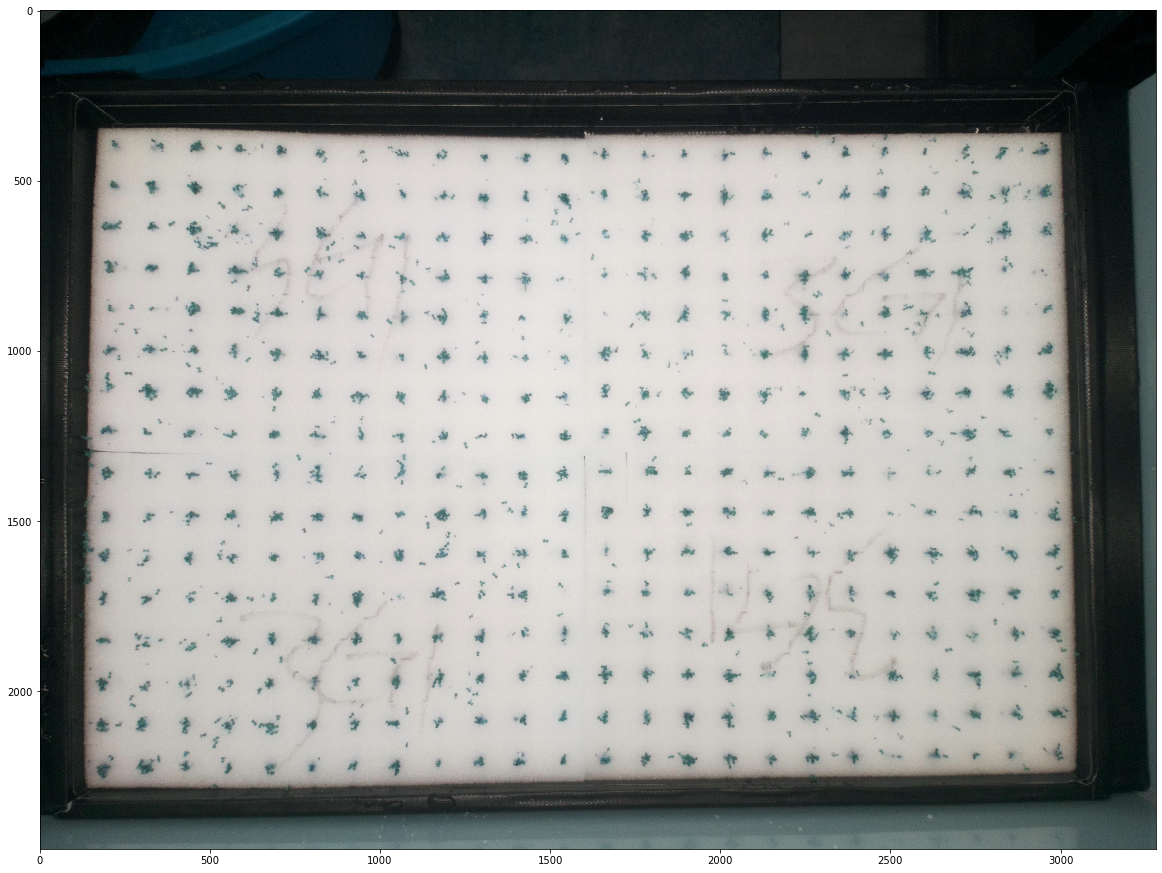

In [3]:
# 裁切目標範圍

imgPath="./images/13G1_4_ea0f9a1eaea911ea82d6b42e99c8ec5d.jpg"  # 檔案路徑
image = cv2.imread(imgPath,1)  # 讀取影像

img_copy = image.copy()  # 複製影像
paper = cv2.GaussianBlur(img_copy, (5, 5), 0)  # 糊化 消除雜訊
ret, thresh_gray = cv2.threshold(
    cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY),  # 轉換灰階
    100, 255, cv2.THRESH_BINARY  # 二元化
)
# erosion = cv2.erode(thresh_gray,(39, 39),iterations = 2)  # 腐蝕，排除更多雜訊
# plt.imshow(erosion)
contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #　尋找邊界，cv2.RETR_EXTERNAL不找被框住的範圍內（但不知道為什麼還是會抓．．．）

for c in contours:
    rect = cv2.minAreaRect(c)  # 找中心點
    box = cv2.boxPoints(rect)  # 找四頂點
    # convert all coordinates floating point values to int
    box = np.int0(box)  # 資料型態轉換
    x = []  # x軸
    y = []  # y軸
#     cv2.drawContours(img_copy, [box], 0, (0, 255, 0),5)  # 畫出邊界(可以不用)
    for i in range(0, 4):
        x.append(box[i][0])  # 抓四頂點的X
        y.append(box[i][1])  # 抓四頂點的Y
    if (max(x)-min(x)) > 1000 and (max(y)-min(y)) > 1000:  # 圖形符合整塊海綿的大小才取用
        global tar
        tar = box
#         print(tar)
        # draw a green 'nghien' rectangle
        cv2.drawContours(img_copy, [np.int0(tar)], 0, (0, 255, 0),5)  # 畫出邊界(可以不用)
        M = cv2.moments(c)  # 計算動差函數
        cX = int(M["m10"] / M["m00"])  # 尋找中心點Ｘ軸
        cY = int(M["m01"] / M["m00"])  # 尋找中心點Ｙ軸
        cv2.circle(img_copy, (cX, cY), 10, (1, 227, 254), 50)  # 標示出中心點位置
        sumxy = []
        for i in c:
            sumxy.append(i[0][0]+i[0][1])

        rb = tuple(c[sumxy.index(max(sumxy))][0].tolist())
        tl = tuple(c[sumxy.index(min(sumxy))][0].tolist())

        divxy = []
        for i in c:
            divxy.append(i[0][0]-i[0][1])

        rt = tuple(c[divxy.index(max(divxy))][0].tolist())
        lb = tuple(c[divxy.index(min(divxy))][0].tolist()) 
        cv2.circle(img_copy, rb, 20, (255, 0, 0), 5)
        cv2.circle(img_copy, tl, 20, (255, 0, 0), 5)
        cv2.circle(img_copy, rt, 20, (255, 0, 0), 5)
        cv2.circle(img_copy, lb, 20, (255, 0, 0), 5)
        break
        
point = [rb, tl, rt, lb]
x = 24
y = 16
rect = four_point_transform(image, np.array(point))  #用目標四頂點拉伸圖片
image_convert = cv2.resize(rect,(100*x, 100*y))  # 調整影像大小
# plt.imshow(img_copy)  # 顯示用四頂點轉換拉伸後的圖
plt.imshow(image)  # 顯示用四頂點轉換拉伸後的圖

In [3]:
# 二元化
kernel_size = (9, 9)  # 高斯模糊矩陣大小
sigma = 6  # 高斯模糊標準差參數(0=自動)
thresholds = 120
grayImage = cv2.cvtColor(image_convert, cv2.COLOR_BGR2GRAY)  # gray(0-255) 圖像轉換灰階
GaussianImage = cv2.GaussianBlur(grayImage, kernel_size, sigma)  # GaussianBlur  圖校進行模糊化(高斯)
block_size = 79
local_thresh1 = threshold_local(GaussianImage, block_size, offset=20, method='gaussian')
binary_local1 = GaussianImage > local_thresh1

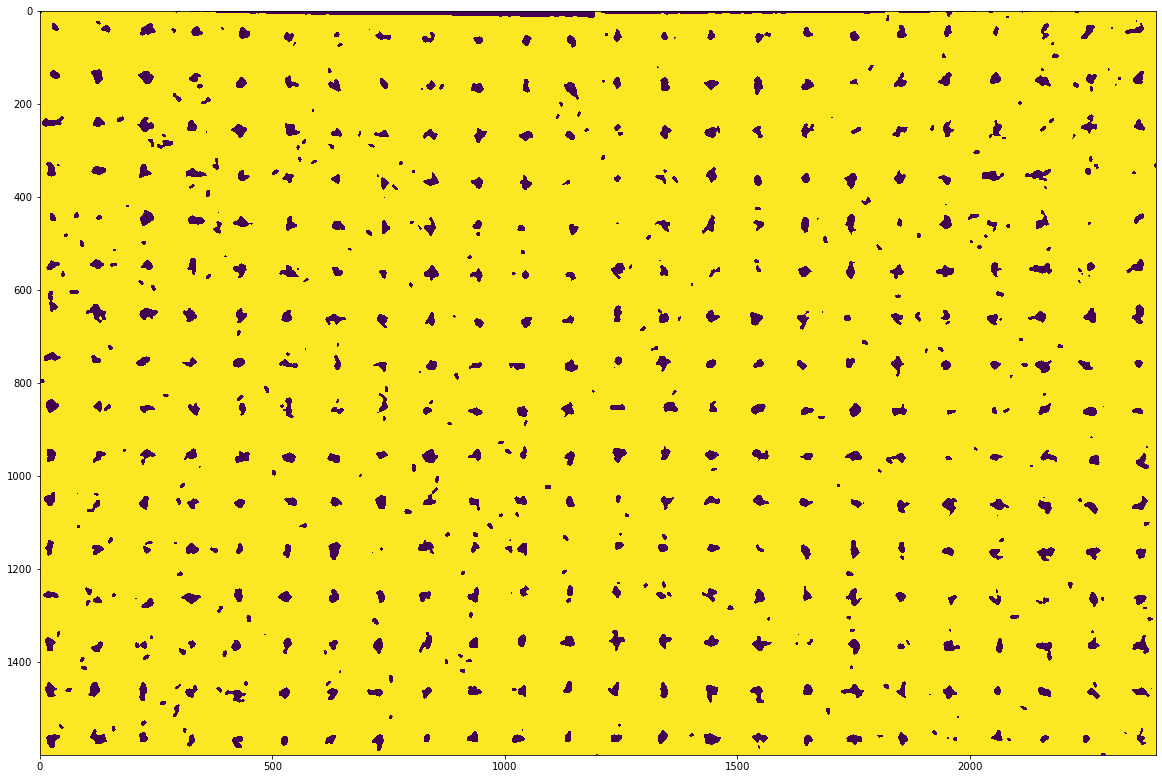

In [4]:
# 計算發芽率
# 13G2  2.0
# 12GK  4.1
# 13G1  4.0
top = 0  # 最上面(+h)
left = 0  # 最左邊(+w)
plus = 100  # 長寬設定 100 * 100
result = []
for i in range(y):3
    for j in range(x):
        preview = image_convert[top:top+plus, left:left+plus]
        slice_img = binary_local1[top:top+plus, left:left+plus]
        filename = '%s-%s_13G2.jpg' % (i, j)
        cv2.imwrite('./13G2/' + filename, preview)
        caculateImg = slice_img[10:90, 10:90]  # 邊緣10%不計算發芽率
        slice_percent =  round(sum(sum(caculateImg == 0))/64, 2)  # 計算黑色比例(作物占比)
        if slice_percent > 2.0:
            is_germination = 1
        else:
            is_germination = 0
        result.append([i, j, slice_percent, is_germination, slice_img])
        left = left + plus
    top = top +plus
    left = 0  # 算完一列重製(like a打字機)

plt.imshow(binary_local1)

In [25]:
species = 4
dict_pieces = {
    '4':[range(0,8), range(0,12)],
    '3':[range(0,8), range(12,24)],
    '2':[range(8,16), range(0,12)],
    '1':[range(8,16), range(12,24)],
}
for i in range(species):
    print(i)
    print(dict_pieces[str(i+1)])
    print(len(dict_pieces[str(i+1)][0]), len(dict_pieces[str(i+1)][1]))
    for x in dict_pieces[str(i+1)][0]:
        for y in dict_pieces[str(i+1)][1]:
            print(x, y)

8 12
8 13
8 14
8 15
8 16
8 17
8 18
8 19
8 20
8 21
8 22
8 23
9 12
9 13
9 14
9 15
9 16
9 17
9 18
9 19
9 20
9 21
9 22
9 23
10 12
10 13
10 14
10 15
10 16
10 17
10 18
10 19
10 20
10 21
10 22
10 23
11 12
11 13
11 14
11 15
11 16
11 17
11 18
11 19
11 20
11 21
11 22
11 23
12 12
12 13
12 14
12 15
12 16
12 17
12 18
12 19
12 20
12 21
12 22
12 23
13 12
13 13
13 14
13 15
13 16
13 17
13 18
13 19
13 20
13 21
13 22
13 23
14 12
14 13
14 14
14 15
14 16
14 17
14 18
14 19
14 20
14 21
14 22
14 23
15 12
15 13
15 14
15 15
15 16
15 17
15 18
15 19
15 20
15 21
15 22
15 23
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 

done, showing...


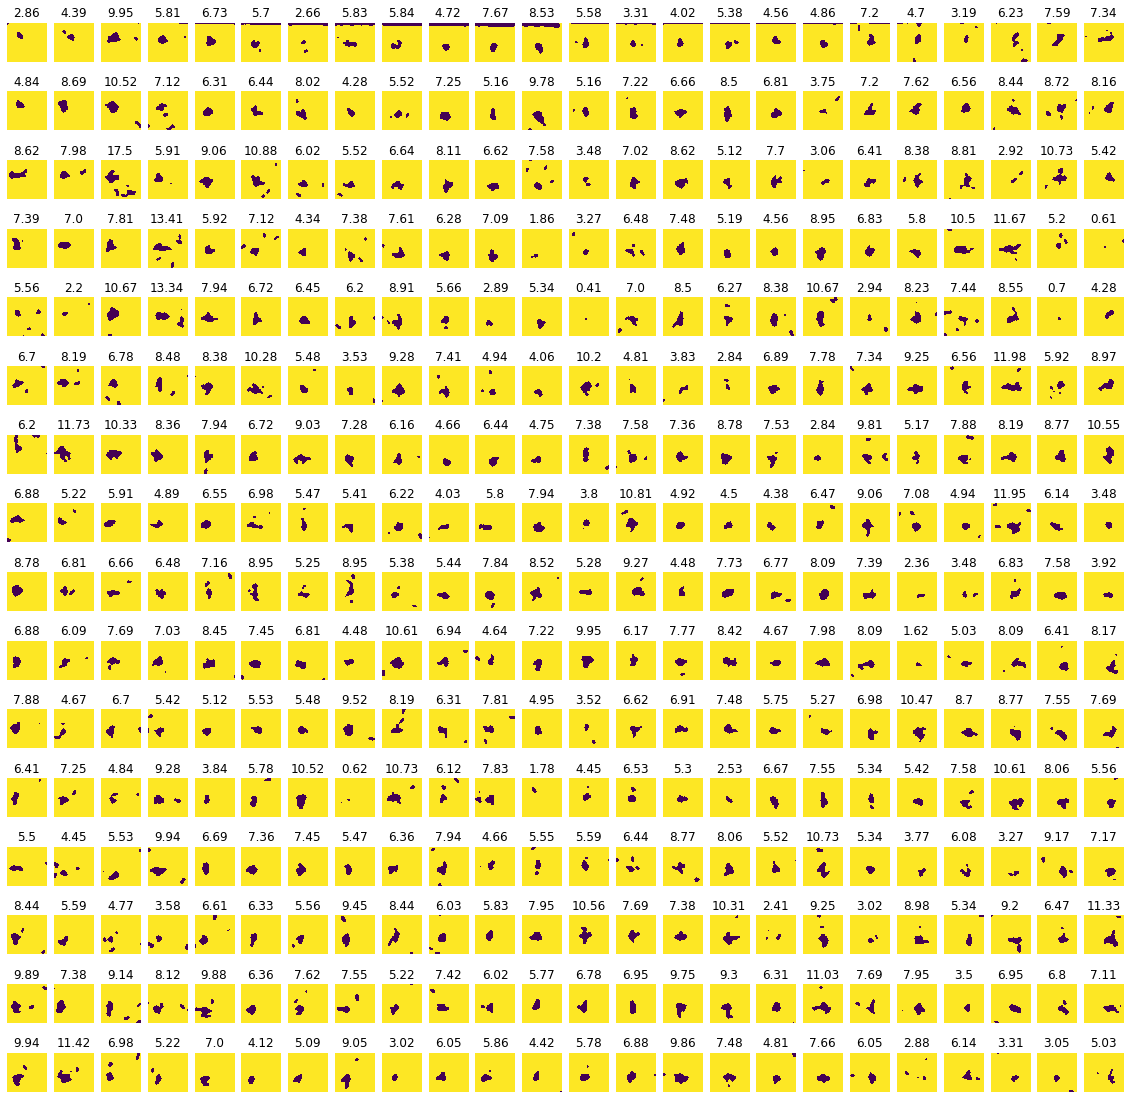

In [5]:
species = 4
dict_pieces = {
    '4':[range(0,8), range(0,12)],
    '3':[range(0,8), range(12,24)],
    '2':[range(8,16), range(0,12)],
    '1':[range(8,16), range(12,24)],
}

type(result)
sorted(result,key=lambda l:l[2], reverse=False)
fig = plt.figure(figsize=(20, 20))
columns = 24
rows = 16
for i in range(1, columns*rows +1):
    img = result[i-1][4]
    fig.add_subplot(rows, columns, i)
    plt.title(str(result[i-1][2]))
    plt.axis('off')
    plt.imshow(img)
print('done, showing...')
plt.show()

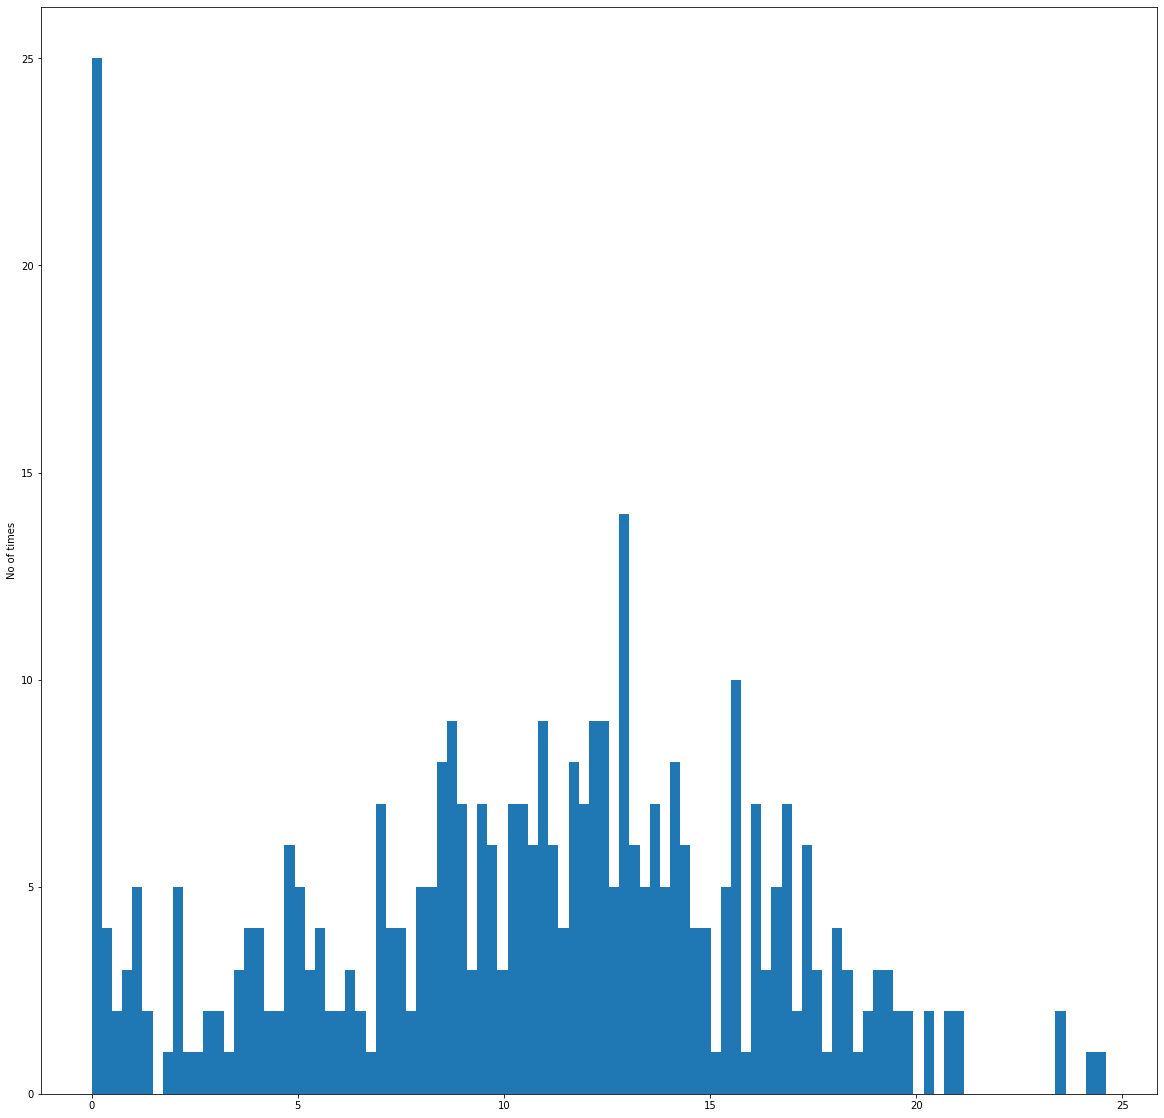

In [38]:
import matplotlib.pyplot as plt
histdata = []
for i in result:
    histdata.append(i[2])
plt.hist(histdata, bins=100)
plt.ylabel('No of times')
plt.show()

In [32]:
# 計算發芽率
germination_sum = 0
for i in result:
    germination_sum += i[3]
germination_rate = round((germination_sum / (x*y))*100, 2)
print(germination_rate)

82.55


In [103]:
class germination():
    def __init__(self, series_id, germination_percent):
        self.series_id = series_id
        self.germination_percent = germination_percent
        self.result_list = []  #預設結果儲存物件
        self.xy = (24, 16)
        
    def convert_image(self, image):  # 取出海綿的範圍，回傳照片與預覽圖(含點線)
        img_preview = image.copy()  # 複製影像
        paper = cv2.GaussianBlur(image, (5, 5), 0)  # 糊化 消除雜訊
        ret, thresh_gray = cv2.threshold(
            cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY),  # 轉換灰階
            100, 255, cv2.THRESH_BINARY  # 二元化
        )
        contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #　尋找邊界，cv2.RETR_EXTERNAL不找被框住的範圍內（但不知道為什麼還是會抓．．．）
        for c in contours:
            rect = cv2.minAreaRect(c)  # 找中心點
            box = cv2.boxPoints(rect)  # 找四頂點
            box = np.int0(box)  # 資料型態轉換
            x = []  # x軸
            y = []  # y軸
            for i in range(0, 4):
                x.append(box[i][0])  # 抓四頂點的X
                y.append(box[i][1])  # 抓四頂點的Y
            if (max(x)-min(x)) > 2000 and (max(y)-min(y)) > 1000:  # 圖形符合整塊海綿的大小才取用
                global tar
                tar = box
                cv2.drawContours(image, [np.int0(tar)], 0, (0, 255, 0),5)  # 畫出邊界(可以不用)
                M = cv2.moments(c)  # 計算動差函數
                cX = int(M["m10"] / M["m00"])  # 尋找中心點Ｘ軸
                cY = int(M["m01"] / M["m00"])  # 尋找中心點Ｙ軸
                cv2.circle(img_preview, (cX, cY), 10, (1, 227, 254), 50)  # 標示出中心點位置
                sumxy = []
                for i in c:
                    sumxy.append(i[0][0]+i[0][1])
                rb = tuple(c[sumxy.index(max(sumxy))][0].tolist())
                tl = tuple(c[sumxy.index(min(sumxy))][0].tolist())
                divxy = []
                for i in c:
                    divxy.append(i[0][0]-i[0][1])
                rt = tuple(c[divxy.index(max(divxy))][0].tolist())
                lb = tuple(c[divxy.index(min(divxy))][0].tolist()) 
                cv2.circle(img_preview, rb, 20, (255, 0, 0), 5)
                cv2.circle(img_preview, tl, 20, (255, 0, 0), 5)
                cv2.circle(img_preview, rt, 20, (255, 0, 0), 5)
                cv2.circle(img_preview, lb, 20, (255, 0, 0), 5)
                break
        point = [rb, tl, rt, lb]
        rect = four_point_transform(image, np.array(point))  #用目標四頂點拉伸圖片
        image_convert = cv2.resize(rect,(100*self.xy[0], 100*self.xy[1]))  # 調整影像大小
        return image_convert, img_preview
    
    def binary(self, image):  # 圖像二元化
        kernel_size = (9, 9)  # 高斯模糊矩陣大小
        sigma = 6  # 高斯模糊標準差參數(0=自動)
        thresholds = 120
        grayImage = cv2.cvtColor(image_convert, cv2.COLOR_BGR2GRAY)  # gray(0-255) 圖像轉換灰階
        GaussianImage = cv2.GaussianBlur(grayImage, kernel_size, sigma)  # GaussianBlur  圖校進行模糊化(高斯)
        block_size = 79
        local_thresh1 = threshold_local(GaussianImage, block_size, offset=20, method='gaussian')
        binary_local1 = GaussianImage > local_thresh1
        return binary_local1
    
    def caculate(self, binary_image, convert_image):
        # 計算發芽率
        top = 0  # 最上面(+h)
        left = 0  # 最左邊(+w)
        plus = 100  # 長寬設定 100 * 100
        for i in range(self.xy[1]):
            for j in range(self.xy[0]):
                slice_img = convert_image[top:top+plus, left:left+plus]
                slice_img_binary = binary_image[top:top+plus, left:left+plus]
                caculateImg = slice_img_binary[10:90, 10:90]  # 邊緣10%不計算發芽率
                slice_percent =  round(sum(sum(caculateImg == 0))/64, 2)  # 計算黑色比例(作物占比)
                if slice_percent > 1.5:
                    is_germination = 1
                else:
                    is_germination = 0
                self.result_list.append([i, j, slice_percent, is_germination, slice_img])
                left = left + plus
            top = top +plus
            left = 0  # 算完一列重製(like a打字機)
        germination_sum = 0
        for i in self.result_list:
            germination_sum += i[3]
        germination_rate = round((germination_sum / (self.xy[0]*self.xy[1]))*100, 2)
        return germination_rate
    
    def identify(self, image):
        convert_image, convert_image_preview = self.convert_image(image)
        binary_image = self.binary(convert_image)
        caculate = self.caculate(binary_image, convert_image)
        return caculate

In [104]:
ger = germination('3G1', 1.8)
imgPath="./3G1-2.jpg"  # 檔案路徑
image = cv2.imread(imgPath,1)  # 讀取影像
ger.identify(image)
# ger.result_list[0][4]

97.4

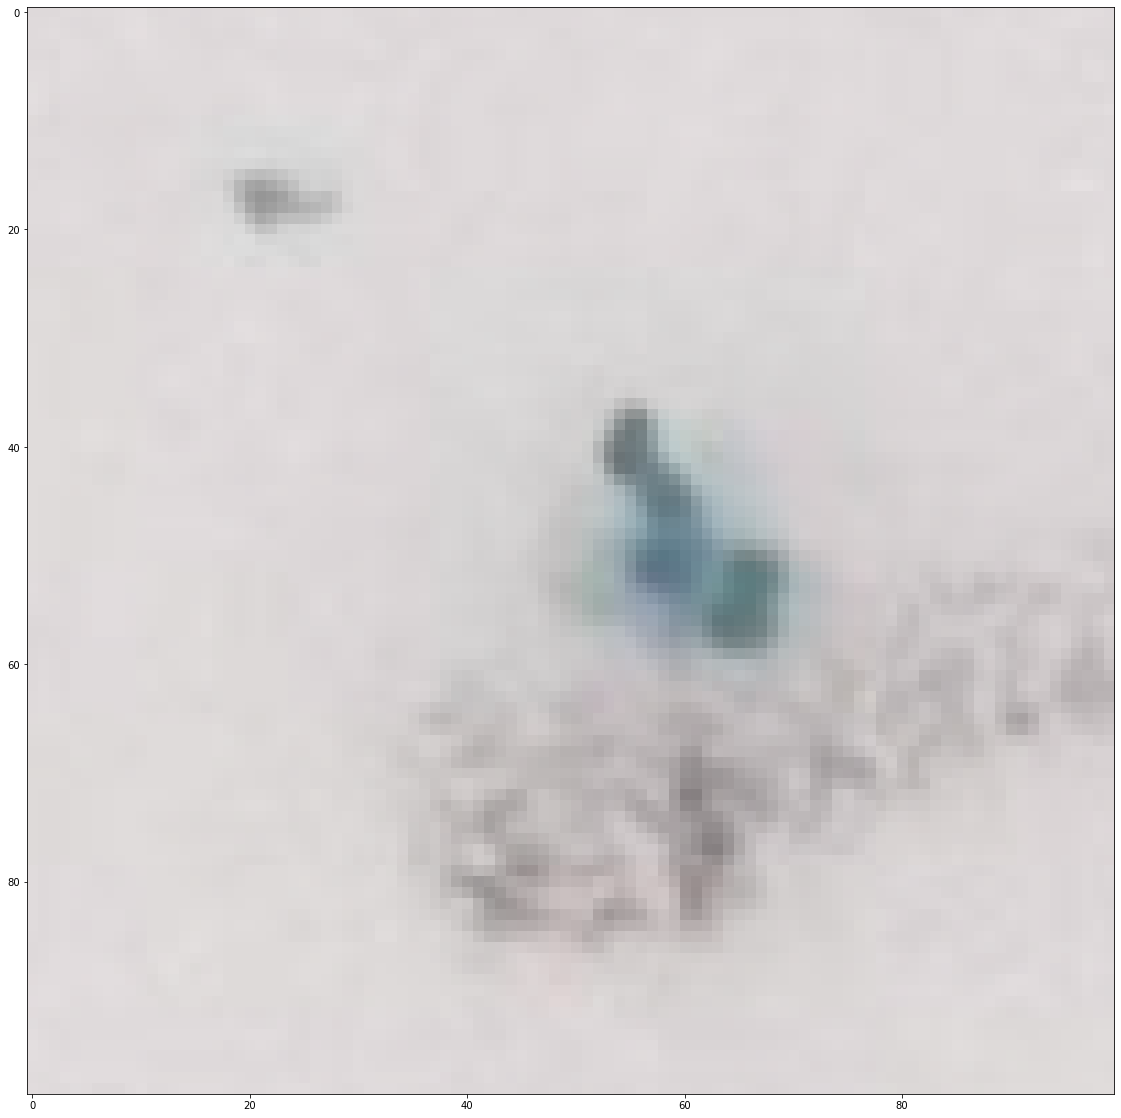

In [108]:
aaa = ger.result_list[100][4]
bt = cv2.imencode('.jpg', aaa)[1].tostring()  # numpy array convert to bytes type for blob type
plt.imshow(aaa, cmap='Greys',  interpolation='nearest')

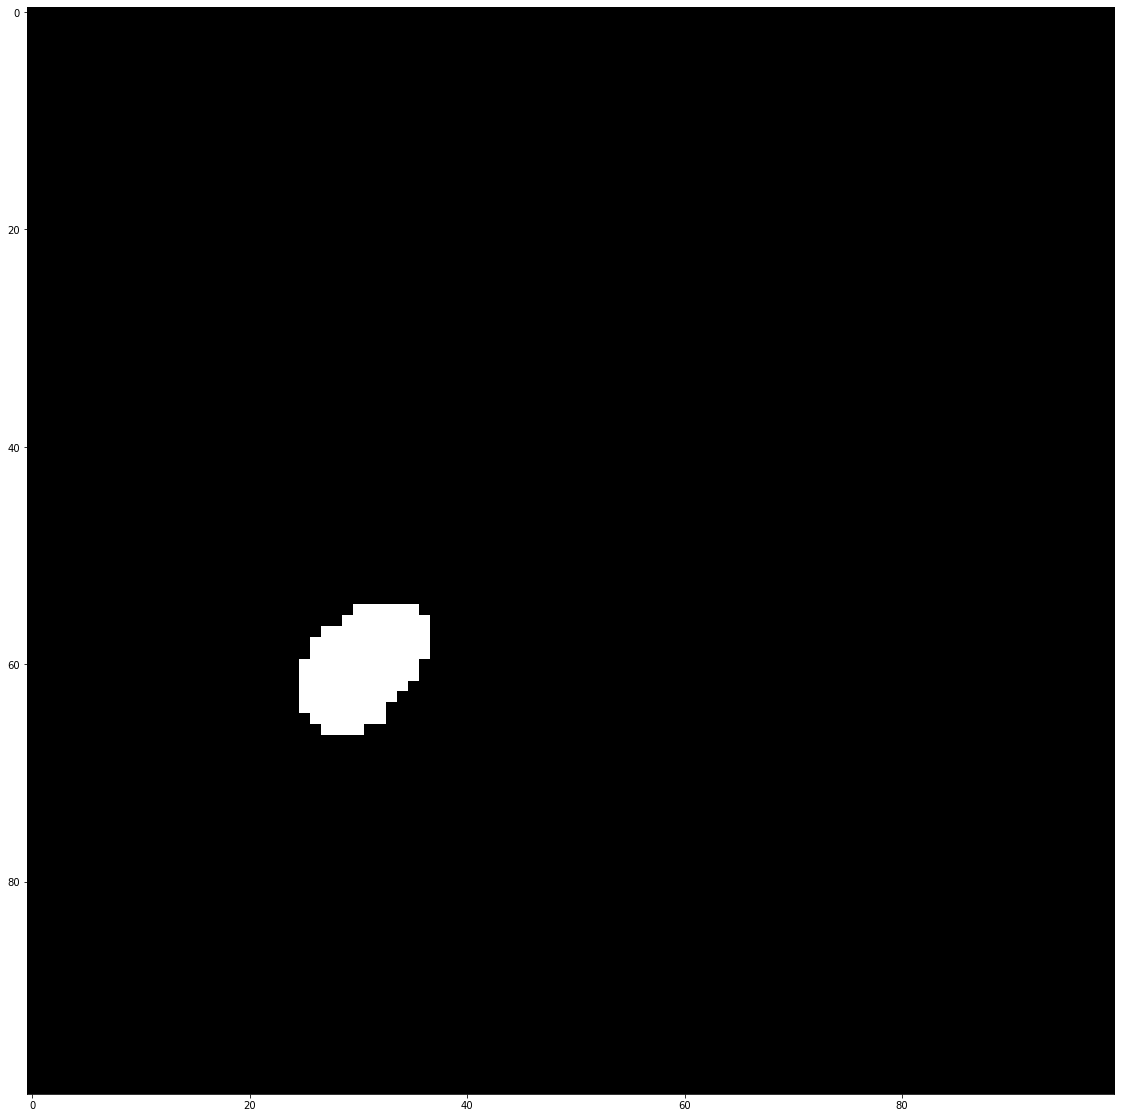

In [95]:
from skimage import img_as_ubyte
aaa = ger.result_list[300][4]
cv_image = img_as_ubyte(aaa)
bt = cv2.imencode('.jpg', cv_image)[1].tostring()  # numpy array convert to bytes type for blob type
plt.imshow(cv_image, cmap='Greys',  interpolation='nearest')

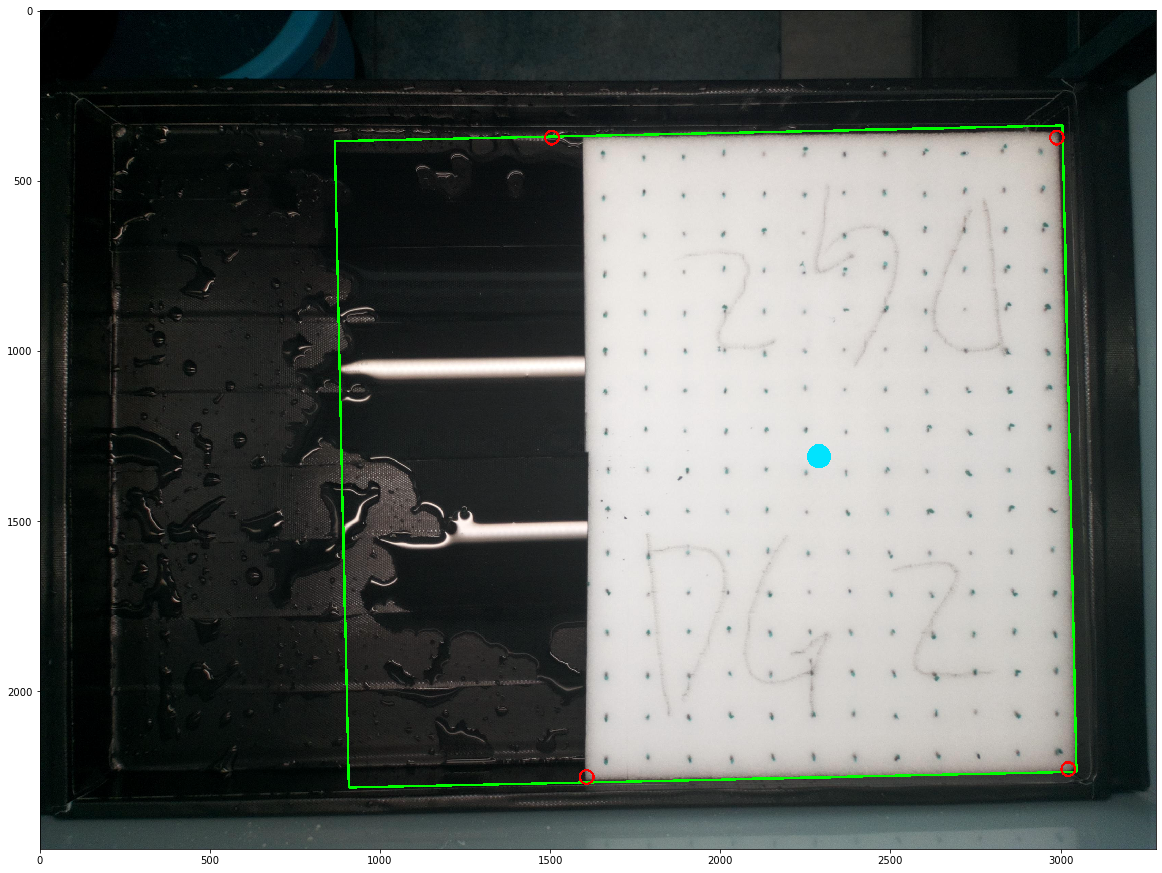

In [7]:
# 辨識三片
# 裁切目標範圍

imgPath="./13G2_2_f8d8fc9cadda11ea92e7b42e99c8ec5d.jpg"  # 檔案路徑
image = cv2.imread(imgPath,1)  # 讀取影像

img_copy = image.copy()  # 複製影像
paper = cv2.GaussianBlur(img_copy, (5, 5), 0)  # 糊化 消除雜訊
ret, thresh_gray = cv2.threshold(
    cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY),  # 轉換灰階
    100, 255, cv2.THRESH_BINARY  # 二元化
)
# erosion = cv2.erode(thresh_gray,(39, 39),iterations = 2)  # 腐蝕，排除更多雜訊
# plt.imshow(erosion)
contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)  #　尋找邊界，cv2.RETR_EXTERNAL不找被框住的範圍內（但不知道為什麼還是會抓．．．）

for c in contours:
    rect = cv2.minAreaRect(c)  # 找中心點
    box = cv2.boxPoints(rect)  # 找四頂點
    # convert all coordinates floating point values to int
    box = np.int0(box)  # 資料型態轉換
    x = []  # x軸
    y = []  # y軸
#     cv2.drawContours(img_copy, [box], 0, (0, 255, 0),5)  # 畫出邊界(可以不用)
    for i in range(0, 4):
        x.append(box[i][0])  # 抓四頂點的X
        y.append(box[i][1])  # 抓四頂點的Y
    if (max(x)-min(x)) > 1000 and (max(y)-min(y)) > 1000:  # 圖形符合整塊海綿的大小才取用
        global tar
        tar = box
#         print(tar)
        # draw a green 'nghien' rectangle
        cv2.drawContours(img_copy, [np.int0(tar)], 0, (0, 255, 0),5)  # 畫出邊界(可以不用)
        M = cv2.moments(c)  # 計算動差函數
        cX = int(M["m10"] / M["m00"])  # 尋找中心點Ｘ軸
        cY = int(M["m01"] / M["m00"])  # 尋找中心點Ｙ軸
        cv2.circle(img_copy, (cX, cY), 10, (1, 227, 254), 50)  # 標示出中心點位置
        sumxy = []
        for i in c:
            sumxy.append(i[0][0]+i[0][1])

        rb = tuple(c[sumxy.index(max(sumxy))][0].tolist())
        tl = tuple(c[sumxy.index(min(sumxy))][0].tolist())

        divxy = []
        for i in c:
            divxy.append(i[0][0]-i[0][1])

        rt = tuple(c[divxy.index(max(divxy))][0].tolist())
        lb = tuple(c[divxy.index(min(divxy))][0].tolist()) 
        cv2.circle(img_copy, rb, 20, (255, 0, 0), 5)
        cv2.circle(img_copy, tl, 20, (255, 0, 0), 5)
        cv2.circle(img_copy, rt, 20, (255, 0, 0), 5)
        cv2.circle(img_copy, lb, 20, (255, 0, 0), 5)
        break
        
point = [rb, tl, rt, lb]
x = 12
y = 16
rect = four_point_transform(image, np.array(point))  #用目標四頂點拉伸圖片
image_convert = cv2.resize(rect,(100*x, 100*y))  # 調整影像大小
plt.imshow(img_copy)  # 顯示用四頂點轉換拉伸後的圖
# plt.imshow(image_convert)  # 顯示用四頂點轉換拉伸後的圖

In [5]:
from germination.yy_class import callDB, par, germination
import cv2

imgPath="./images/13G1_4_ea0f9a1eaea911ea82d6b42e99c8ec5d.jpg"  # 檔案路徑
image = cv2.imread(imgPath,1)  # 讀取影像

series_id = '13G1'
pieces = 1
percent = 2.0
ger = germination(series_id, percent, pieces)
res, ger_cnt = ger.identify(image)
print(res, ger_cnt, len(ger.result_list))

98.96 95 96


In [11]:
imgPath="./images/13G1_4_ea0f9a1eaea911ea82d6b42e99c8ec5d.jpg"  # 檔案路徑
image = cv2.imread(imgPath,1)  # 讀取影像
convert_image, convert_image_preview = ger.convert_image(image)
binary_image = ger.binary(convert_image)


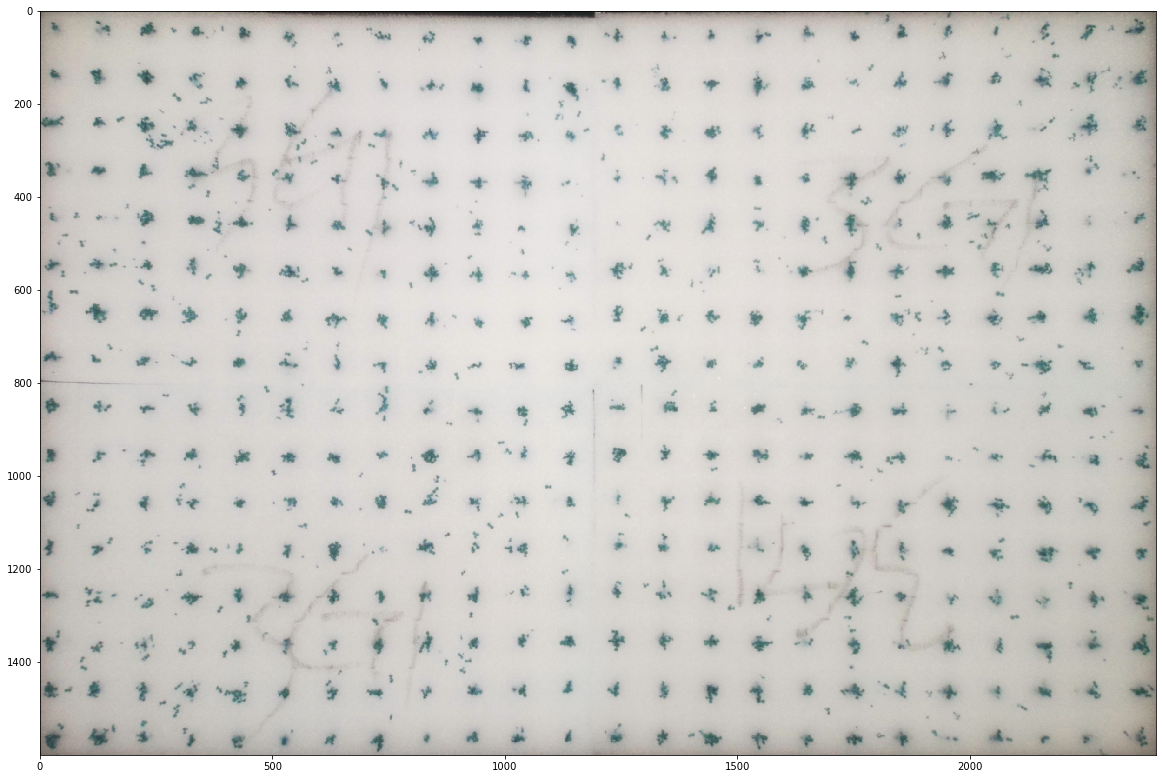

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)
plt.imshow(convert_image)

In [15]:
# 照片存入DB
image_id = 'image_' + uuid.uuid1().hex
db = pymysql.connect(host='127.0.0.1',
                             port=3306,
                             user='root',
                             password='jimmy0911',
                             db='yyostech_2')
cursor = db.cursor()
img = cv2.imread('3G1-2.jpg', 1)
bt = cv2.imencode('.jpg', img)[1].tostring()  # numpy array convert to bytes type for blob type
try:
    sql='''
        insert into yyostech_2.raspi_image (image_id, image, create_datetime) 
            value (%s, %s, %s)
        '''
    cursor.execute(sql, (image_id, bt, str(time.strftime('%Y-%m-%d %H:%M:%S'))))
    db.commit()
    print('==========================')
    print('done')
except:
    print('error')
    db.rollback()
finally:
    cursor.close()
    db.close()

done


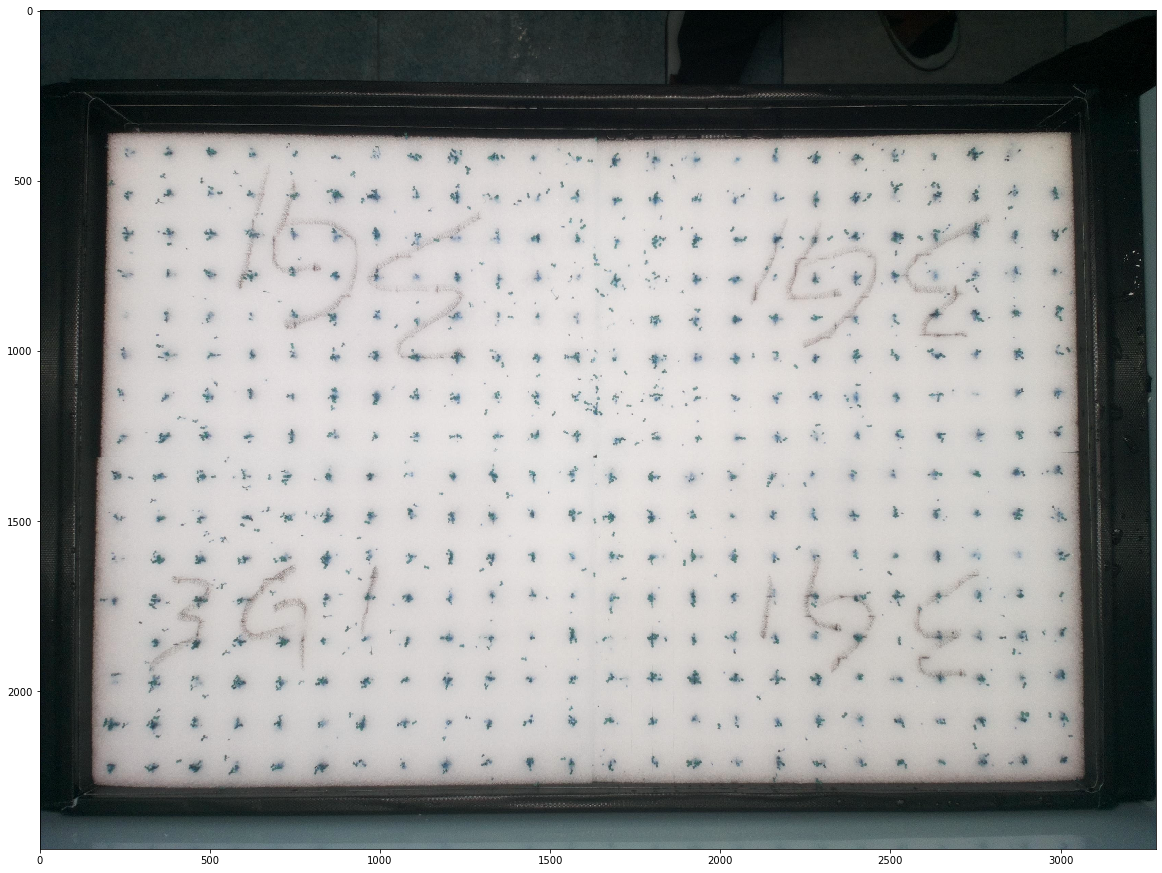

In [23]:
# 取得照片
def get_view_photo(image_id):
    try:
        db = pymysql.connect(host='127.0.0.1',
                             port=3306,
                             user='root',
                             password='jimmy0911',
                             db='yyostech_2')
        cursor = db.cursor()
        sql='''
            select * from yyostech_2.raspi_image where image_id = %s;
            '''
        cursor.execute(sql, (image_id, ))
        data = cursor.fetchone()
        frame = data[1]
        nparr = np.frombuffer(frame, np.uint8)
        frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        previewSize = (int(round(frame.shape[1]/10, 0)), int(round(frame.shape[0]/10, 0)))
        previewImage = cv2.resize(frame, previewSize)
    finally:
        cursor.close()
        db.close()
    return previewImage

def get_use_photo(image_id):
    try:
        db = pymysql.connect(host='127.0.0.1',
                             port=3306,
                             user='root',
                             password='jimmy0911',
                             db='yyostech_2')
        cursor = db.cursor()
        sql='''
            select * from raspi_image where image_id = %s;
            '''
        cursor.execute(sql, (image_id, ))
        data = cursor.fetchone()
        frame = data[1]
        nparr = np.frombuffer(frame, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    except:
        print('error')
        db.rollback()
    finally:
        cursor.close()
        db.close()
    return image

previewImage = get_view_photo(image_id)
image = get_use_photo(image_id)
plt.imshow(image)

In [ ]:
from germination.yy_class import par, callDB
import uuid
par = par('192.168.50.87', 22, 'pi', 'Jimmy8193026')

dbcnt = callDB('127.0.0.1', 3306, 'root', 'yyos12345678', 'yyostech_2')
photoid = 'photo_'+uuid.uuid1().hex
par.connect_raspi(photoid)
print('照片檔(pid)', photoid)
img = dbcnt.get_view_photo(photoid)
img